# Interface for extensive analysis

By using the [microgeo](https://github.com/ChaonanLi/microgeo) R package, we also can perform more extensive analysis. Here we just give several simple examples.

Here we need three R packages for this section of [microgeo](https://github.com/ChaonanLi/microgeo) R package tutorial. Just run the following codes to import them into R environment.

In [1]:
suppressMessages(require("magrittr")) 
require("ggplot2")  %>% suppressMessages()
require("microgeo") %>% suppressMessages()

If the Chinese characters cannot be displayed correctly, please run the following codes to set locale to `UTF-8`:

In [2]:
prev_locale <- Sys.setlocale("LC_CTYPE", "C.UTF-8") 

We need a standard microgeo dataset for the presentations in the section of tutorial.

In [3]:
# Use the map downloaded from DataV.GeoAtlas
data(qtp)
map <- read_aliyun_map(adcode = c(540000, 630000, 510000)) %>% suppressMessages() # head(map@data)
dataset.dts.aliyun <- create_dataset(mat = qtp$asv, ant = qtp$tax, met = qtp$met, map = map,
                                     phy = qtp$tre, env = qtp$env, lon = "longitude", lat = "latitude")
dataset.dts.aliyun$map@data$NAME <- c("Tibet", "Qinghai", "Sichuan") 
dataset.dts.aliyun %<>% rarefy_count_table()
dataset.dts.aliyun %<>% tidy_dataset()
dataset.dts.aliyun %<>% calc_alpha_div(measures = c("observed", "shannon"))
dataset.dts.aliyun %>% show_dataset()

ℹ [2024-06-09 19:22:00] INFO ==> all samples fall within the map area!

ℹ [2024-06-09 19:22:00] INFO ==> dataset has been created successfully!

ℹ [2024-06-09 19:22:00] INFO ==> use `object %>% show_dataset()` to check the summary of dataset.

ℹ [2024-06-09 19:22:04] INFO ==> the ASV/gene abundance table has been rarefied with a sub-sample depth of 5310

✔ [2024-06-09 19:22:08] SAVE ==> results have been saved to: object$div$alpha



── The Summary of Microgeo Dataset ─────────────────────────────────────────────


ℹ object$mat: 6808 ASVs/genes and 1244 samples [subsample depth: 5310]

ℹ object$ant: 6808 ASVs/genes and 7 annotation levels (Kingdom, Phylum, Class, Order, Family, Genus, Species)

ℹ object$met: 1244 samples and 2 variables (longitude, latitude)

ℹ object$map: a SpatialPolygonsDataFrame with the CRS of '+proj=longlat +datum=WGS84 +no_defs'

ℹ object$phy: a phylogenetic tree with 6808 tip labels

ℹ object$env: 1244 samples and 10 variables




── The Summary of Biogeographic Traits ─────────────────────────────────────────


✔ object$div$alpha: 2 alpha diversity index/indices (observed, shannon)




• To check the summary of dataset, Replace `object` with the variable name of your dataset
• For example, if the variable name is `dataset.dts`you can run `head(dataset.dts$met)` to check the content of `met`


## 1. Correlation analysis within the naive polygons

In [4]:
# Extract a new metadata from a common map
metadata <- dataset.dts.aliyun$map %>% extract_metadata_from_map(met = dataset.dts.aliyun$met)
head(metadata)

,longitude,latitude,NAME,TYPE,FMTS,X.CENTER,Y.CENTER
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
s1,98.20894,33.10321,Sichuan,DataV.GeoAtlas,microgeo,102.6935,30.67454
s2,98.20894,33.10321,Sichuan,DataV.GeoAtlas,microgeo,102.6935,30.67454
s3,98.20894,33.10321,Sichuan,DataV.GeoAtlas,microgeo,102.6935,30.67454
s4,98.20894,33.10321,Sichuan,DataV.GeoAtlas,microgeo,102.6935,30.67454
s5,98.20894,33.10321,Sichuan,DataV.GeoAtlas,microgeo,102.6935,30.67454
s6,98.20639,33.10280,Sichuan,DataV.GeoAtlas,microgeo,102.6935,30.67454


In [5]:
# Calculate the spearman correlation between shannon index and soil pH for each naive polygon[e.g., Sichuan]
cor.res.c.df <- lapply(unique(metadata$NAME), function(name){
    samples <- metadata[which(metadata$NAME == name),] %>% row.names() 
    if (samples %>% length > 5){ # At least five sample for each polygon
        cor.res <- psych::corr.test(dataset.dts.aliyun$div$alpha[samples,]$shannon, 
                                    dataset.dts.aliyun$env[samples,]$pH, method = 'spearman')
        dd <- data.frame(polygon = name, r = cor.res$r, p = cor.res$p)
    }else{
        dd <- data.frame(polygon = name, r = NA, p = NA)
    }
    dd
}) %>% do.call('rbind', .)
head(cor.res.c.df)

,polygon,r,p
,<chr>,<dbl>,<dbl>
1,Sichuan,0.15654338,0.008936398
2,Tibet,0.06827136,0.118549172
3,Qinghai,-0.10385944,0.029017857


In [6]:
# Merge the correlation coefficients with `SpatialPolygonsDataFrame` 
new.map <- dataset.dts.aliyun$map
mapdata.add.data <- lapply(new.map@data$NAME, function(name) {
    d <- cor.res.c.df[which(cor.res.c.df$polygon == name),]
    ddd <- data.frame(r = NA, p = NA, label = NA)
    if (d %>% nrow > 0) {
        ddd <- d[,2:3]
        ddd$label <- paste0("r = ", round(ddd$r, 2), ", p = ", round(ddd$p, 2))
    }
    ddd
}) %>% do.call('rbind', .)
new.map@data <- cbind(new.map@data, mapdata.add.data)
head(new.map@data)

,TYPE,FMTS,NAME,X.CENTER,Y.CENTER,r,p,label
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,DataV.GeoAtlas,microgeo,Tibet,88.38828,31.56375,0.06827136,0.118549172,"r = 0.07, p = 0.12"
2,DataV.GeoAtlas,microgeo,Qinghai,96.04353,35.72640,-0.10385944,0.029017857,"r = -0.1, p = 0.03"
3,DataV.GeoAtlas,microgeo,Sichuan,102.69345,30.67454,0.15654338,0.008936398,"r = 0.16, p = 0.01"


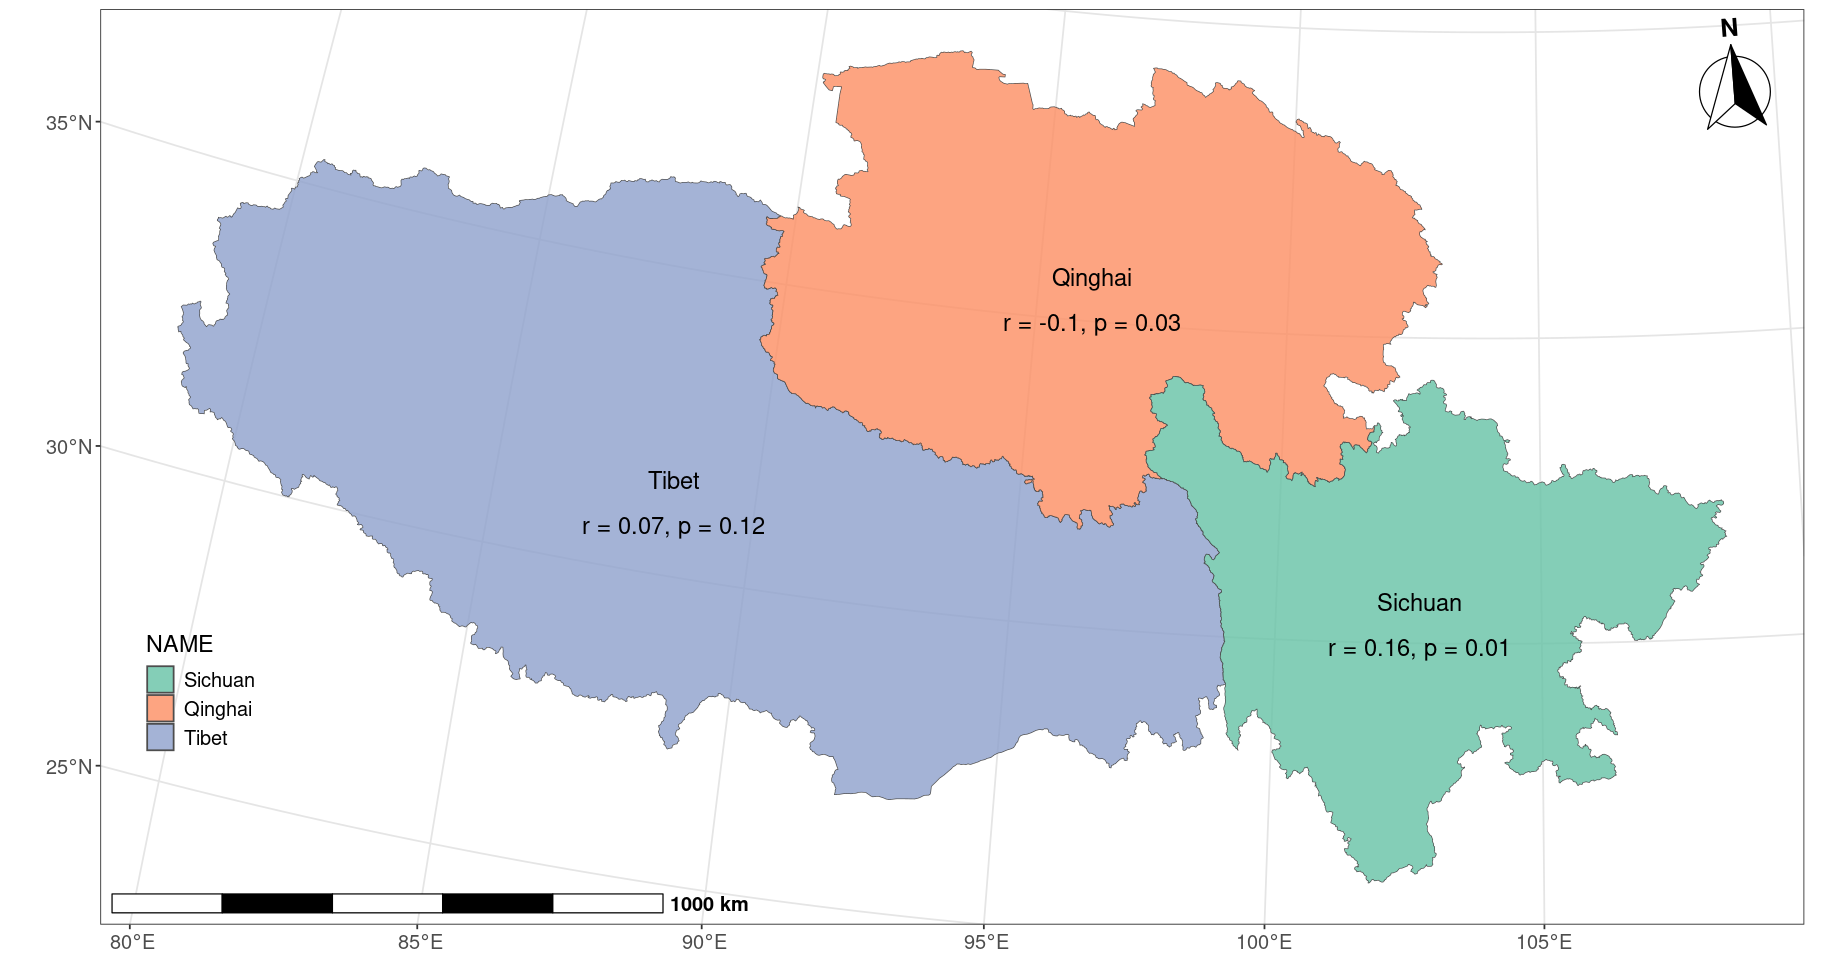

In [7]:
# Visualize the results 
options(repr.plot.width = 15.4, repr.plot.height = 8.02)
new.map %>% plot_bmap(var = 'NAME', ord = c('Sichuan', 'Qinghai', 'Tibet'), 
                      fill = RColorBrewer::brewer.pal(8, "Set2")[1:3], legend.position = c(0.06, 0.255)) %>%
    add_label(dat = new.map@data, lab.var = 'NAME', lon.var = 'X.CENTER', lat.var = 'Y.CENTER', size = 5) %>% 
    add_label(dat = new.map@data, lab.var = 'label', lon.var = 'X.CENTER', lat.var = 'Y.CENTER', size = 5, vjust = 3) %>%
    add_scale_bar() %>% add_north_arrow() %>% add_crs() %>% suppressWarnings()

## 2. Correlation analysis within the grids

In [8]:
# Grid the map using the resolution of 1.5
gridded.map <- grid_map(map = dataset.dts.aliyun$map, res = 1.5) %>% suppressMessages
head(gridded.map@data)

,TYPE,FMTS,NAME,X.CENTER,Y.CENTER
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Gridded.Map,microgeo,1,83.74702,29.73742
2,Gridded.Map,microgeo,2,85.46302,28.50944
3,Gridded.Map,microgeo,3,86.67299,28.33105
4,Gridded.Map,microgeo,4,89.49169,28.25211
5,Gridded.Map,microgeo,5,88.12468,28.29693
6,Gridded.Map,microgeo,6,85.14919,29.46224


In [9]:
# Extract a new metadata from a gridded map
metadata2 <- gridded.map %>% extract_metadata_from_map(met = dataset.dts.aliyun$met)
head(metadata2)

,longitude,latitude,NAME,TYPE,FMTS,X.CENTER,Y.CENTER
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
s1,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s2,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s3,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s4,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s5,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s6,98.20639,33.10280,138,Gridded.Map,microgeo,98.70691,32.50087


In [10]:
# Calculate the spearman correlation between shannon index and soil pH for each grid
cor.res.g.mx <- lapply(unique(metadata2$NAME), function(name){
    samples <- metadata2[which(metadata2$NAME == name),] %>% row.names() 
    if (samples %>% length > 5){ # At least five sample for each grid
        cor.res <- psych::corr.test(dataset.dts.aliyun$div$alpha[samples,]$shannon, 
                                    dataset.dts.aliyun$env[samples,]$pH, method = 'spearman')
        dd <- data.frame(polygon = name, r = cor.res$r, p = cor.res$p)
    }else{
        dd <- data.frame(polygon = name, r = NA, p = NA)
    }
    dd
}) %>% do.call('rbind', .)
head(cor.res.g.mx)

,polygon,r,p
,<chr>,<dbl>,<dbl>
1,138,-0.07939384,0.6041635300
2,152,NA,NA
3,140,0.32588135,0.0183936934
4,136,0.19264945,0.3167137475
5,135,0.70960463,0.0002167925
6,147,0.57134152,0.0018526903


In [11]:
# Merge the correlation coefficients with `SpatialPolygonsDataFrame` 
new.map <- gridded.map
mapdata.add.data <- lapply(new.map@data$NAME, function(name) {
    d <- cor.res.g.mx[which(cor.res.g.mx$polygon == name),]
    ddd <- data.frame(r = NA, p = NA, label = NA)
    if (d %>% nrow > 0) {
        ddd <- d[,2:3]
        ddd$label <- paste0("r = ", round(ddd$r, 2), ", p = ", round(ddd$p, 2))
    }
    ddd
}) %>% do.call('rbind', .)
new.map@data <- cbind(new.map@data, mapdata.add.data)
head(new.map@data)

,TYPE,FMTS,NAME,X.CENTER,Y.CENTER,r,p,label
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Gridded.Map,microgeo,1,83.74702,29.73742,0.313186813,0.2974384,"r = 0.31, p = 0.3"
2,Gridded.Map,microgeo,2,85.46302,28.50944,NA,NA,"r = NA, p = NA"
3,Gridded.Map,microgeo,3,86.67299,28.33105,0.005502068,0.9857673,"r = 0.01, p = 0.99"
4,Gridded.Map,microgeo,4,89.49169,28.25211,NA,NA,"r = NA, p = NA"
5,Gridded.Map,microgeo,5,88.12468,28.29693,-0.078571429,0.7807546,"r = -0.08, p = 0.78"
6,Gridded.Map,microgeo,6,85.14919,29.46224,-0.106086957,0.6217515,"r = -0.11, p = 0.62"


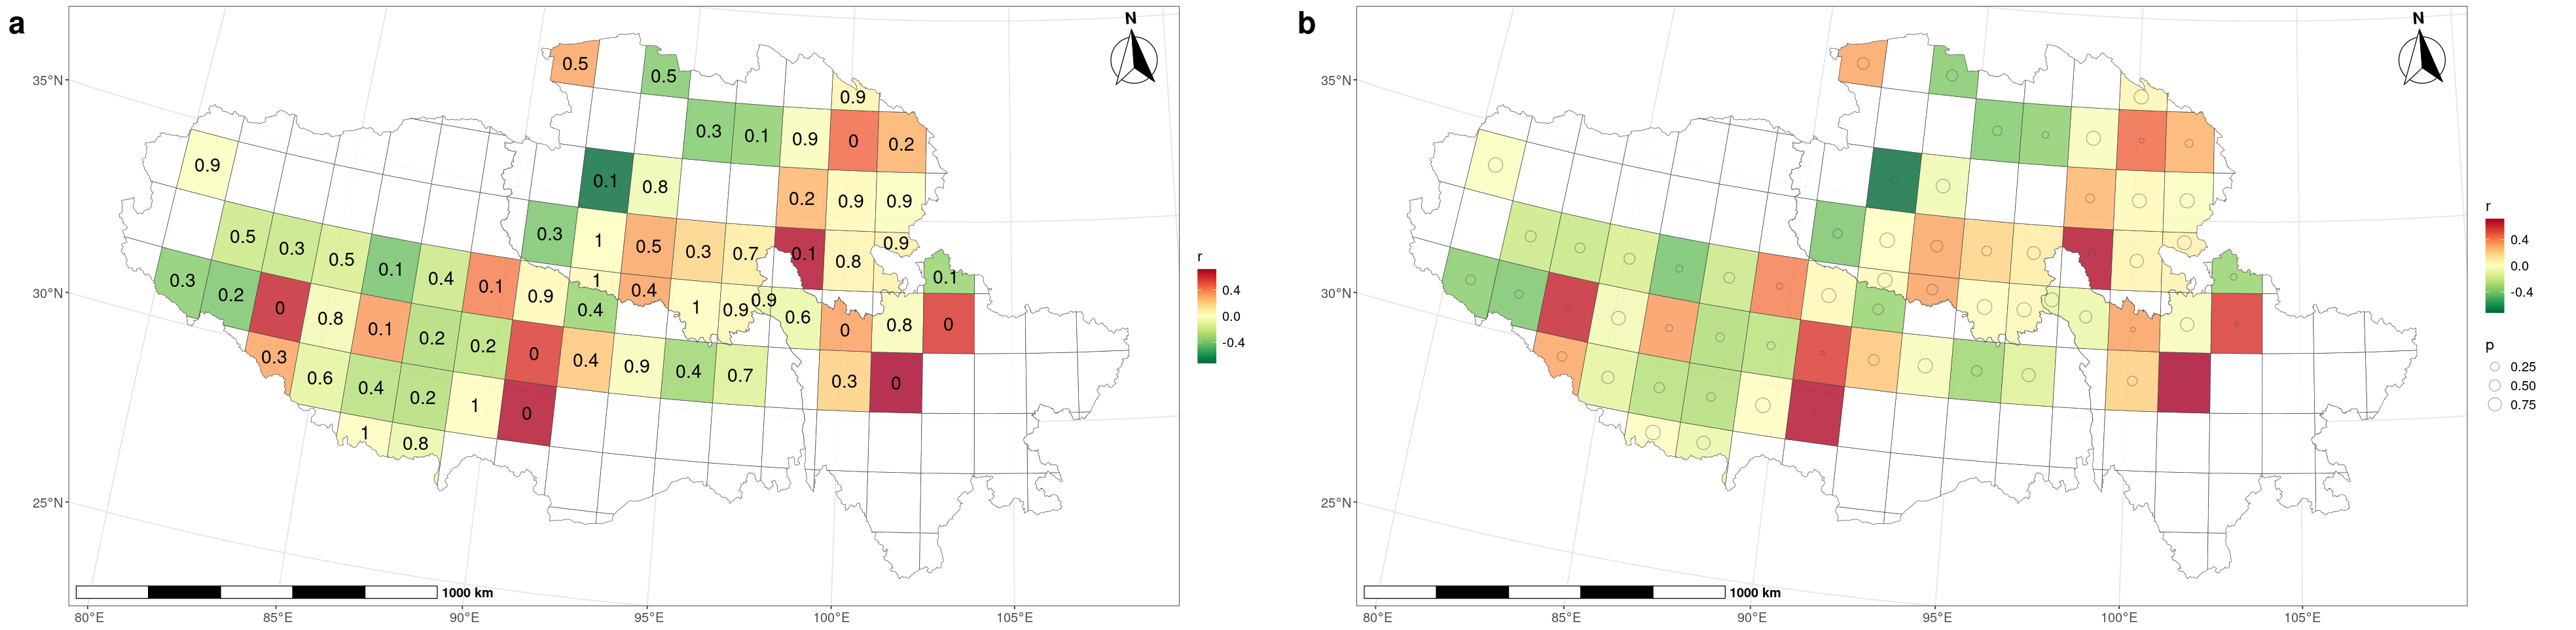

In [12]:
# Visualize the results 
options(repr.plot.width = 16.4 * 2, repr.plot.height = 8.02)
e22 <- new.map %>% plot_bmap(var = 'r', fill = 'auto') %>% 
    add_label(dat = new.map@data, lab.var = 'p', lon.var = 'X.CENTER', lat.var = 'Y.CENTER', size = 6) %>% 
    add_scale_bar() %>% add_north_arrow() %>% add_crs()
e33 <- new.map %>% plot_bmap(var = 'r', fill = 'auto') %>%
    add_point(dat = new.map@data, lab.var = 'p', lon.var = "X.CENTER", lat.var = "Y.CENTER") %>% 
    add_scale_bar() %>% add_north_arrow() %>% add_crs()
cowplot::plot_grid(e22, e33, align = 'hv', ncol = 2, labels = c("a", "b"), label_size = 28) %>% suppressWarnings()

## 3. Analysis based on the clustering of a single variable in each grid

In [13]:
# Grid the map using the resolution of 1.5
gridded.map <- grid_map(map = dataset.dts.aliyun$map, res = 1.5) %>% suppressMessages
head(gridded.map@data) 

,TYPE,FMTS,NAME,X.CENTER,Y.CENTER
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Gridded.Map,microgeo,1,83.74702,29.73742
2,Gridded.Map,microgeo,2,85.46302,28.50944
3,Gridded.Map,microgeo,3,86.67299,28.33105
4,Gridded.Map,microgeo,4,89.49169,28.25211
5,Gridded.Map,microgeo,5,88.12468,28.29693
6,Gridded.Map,microgeo,6,85.14919,29.46224


In [14]:
# Extract a new metadata from a gridded map
metadata3 <- gridded.map %>% extract_metadata_from_map(met = dataset.dts.aliyun$met)
head(metadata3)  

,longitude,latitude,NAME,TYPE,FMTS,X.CENTER,Y.CENTER
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
s1,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s2,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s3,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s4,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s5,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087
s6,98.20639,33.10280,138,Gridded.Map,microgeo,98.70691,32.50087


In [15]:
# Merge alpha diversity indices with a gridded map
gridded.map.mean4df <- merge_dfs_to_map(map = gridded.map, dat = dataset.dts.aliyun$div$alpha, met = dataset.dts.aliyun$met, med = 'mean')
head(gridded.map.mean4df@data[,1:12])

,TYPE,FMTS,NAME,X.CENTER,Y.CENTER,observed_mean,shannon_mean,observed_sd,shannon_sd,observed_se,shannon_se,sample.num
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Gridded.Map,microgeo,1,83.74702,29.73742,592.2308,5.809648,148.1953,0.2310435,41.10199,0.06407995,13
2,Gridded.Map,microgeo,2,85.46302,28.50944,693.0000,5.930691,193.7808,0.2885408,111.87940,0.16658910,3
3,Gridded.Map,microgeo,3,86.67299,28.33105,552.6154,5.781165,146.6819,0.2840750,40.68225,0.07878822,13
4,Gridded.Map,microgeo,4,89.49169,28.25211,663.7500,5.779180,304.4814,0.5449410,152.24069,0.27247051,4
5,Gridded.Map,microgeo,5,88.12468,28.29693,470.3333,5.421891,152.3767,0.4082476,39.34350,0.10540909,15
6,Gridded.Map,microgeo,6,85.14919,29.46224,554.5417,5.746097,147.5472,0.2365089,30.11794,0.04827718,24


In [16]:
# The complete clustering for average shannon index in each grid
dat.new <- data.frame(row.names = gridded.map.mean4df$NAME, val = as.numeric(gridded.map.mean4df$shannon_mean)) %>% na.omit()
cls.num <- fpc::pamk(dat.new)$nc # automatically determining the cluster number
hcs <- hclust(d = dist(dat.new), method = 'complete')
ctr <- cutree(hcs, k = cls.num) %>% as.data.frame()
ctr <- data.frame(grids = rownames(ctr), cluster = ctr[,1])
head(ctr)

,grids,cluster
,<chr>,<int>
1,1,1
2,2,1
3,3,2
4,4,2
5,5,2
6,6,2


Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


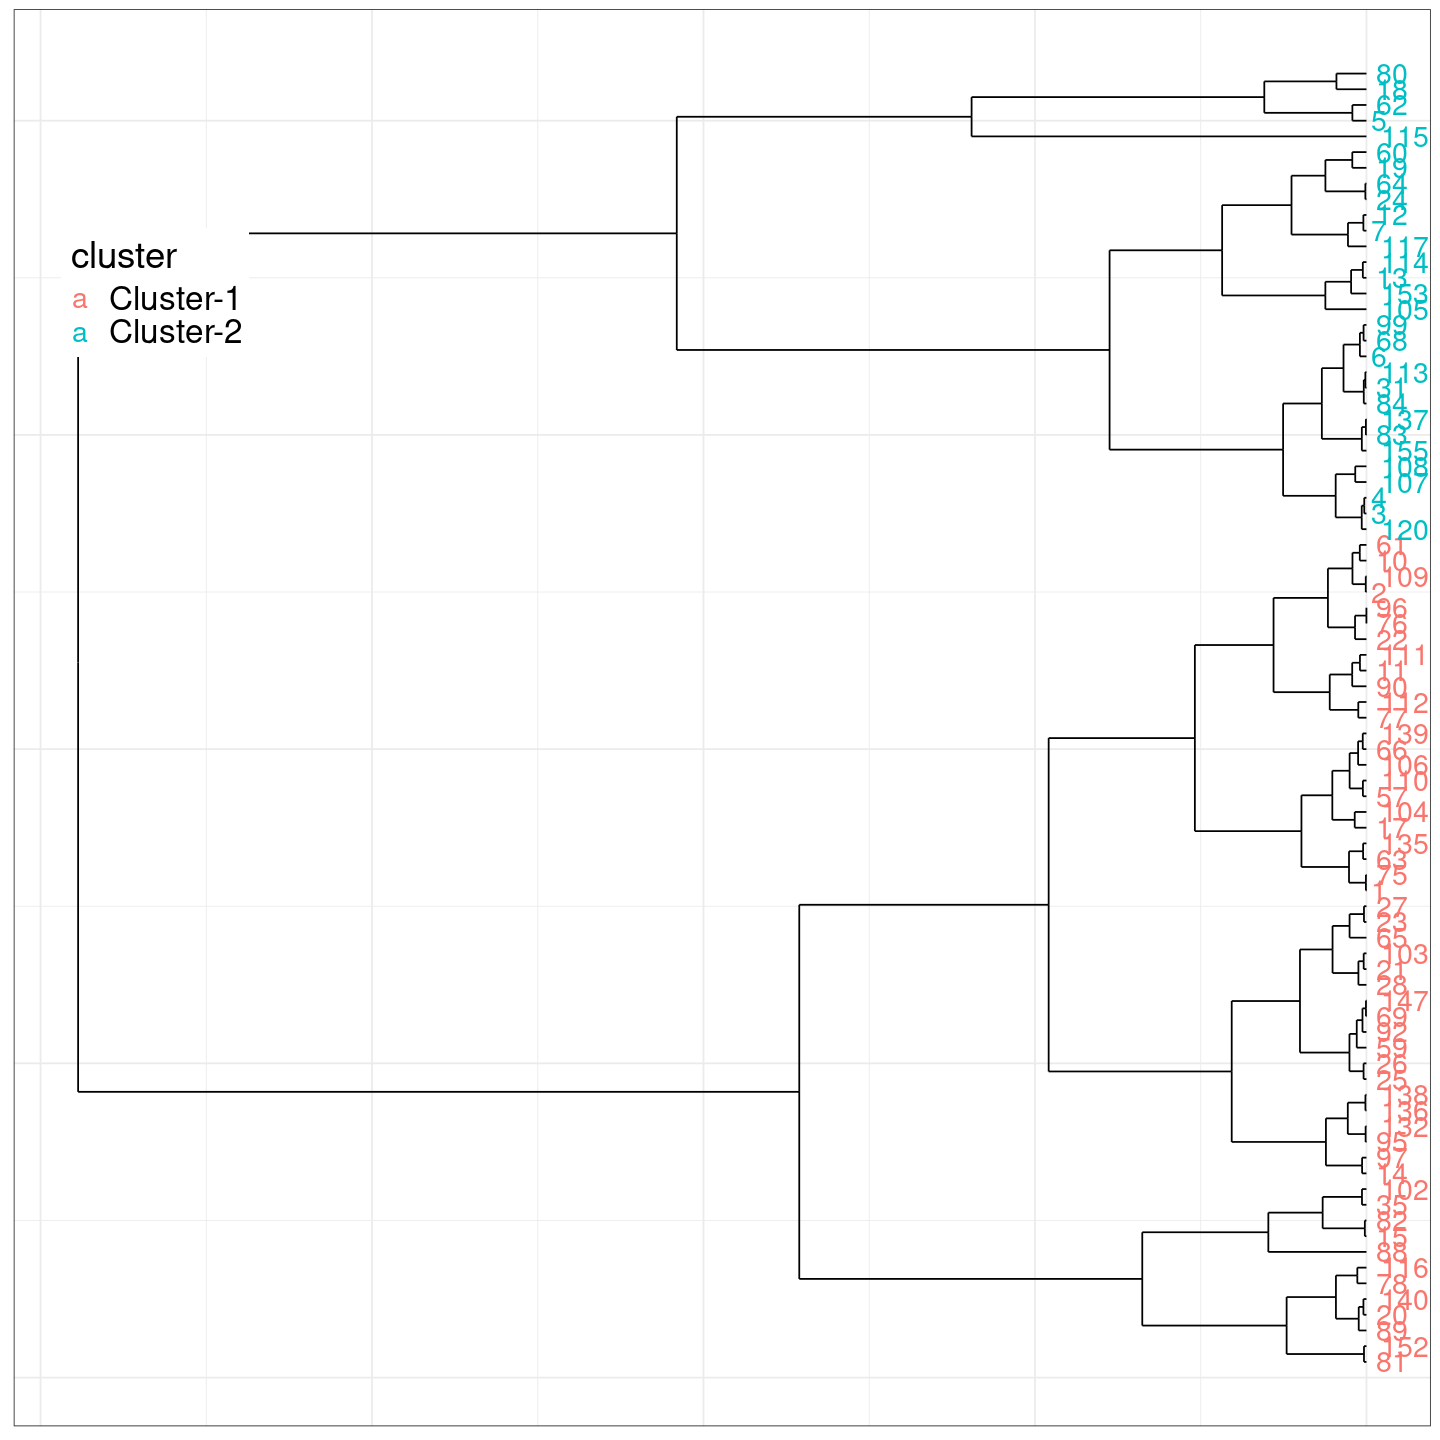

In [17]:
# Visualize the clustering results 
options(repr.plot.width = 12, repr.plot.height = 12)
hc.d <- ggdendro::dendro_data(as.dendrogram(hcs))
hc.d$labels$cluster <- lapply(hc.d$labels$label, function(lab) ctr[which(ctr$grids == lab),]$cluster %>% paste("Cluster", ., sep = "-")) %>% unlist()
ggplot(data = ggdendro::segment(hc.d)) + geom_segment(aes(x=x, y=y, xend=xend, yend=yend)) + theme_bw() + scale_y_reverse() +
    geom_text(data=hc.d$labels, aes(x = x, y = y, label = label, color = cluster), hjust = -0.3, size = 6) +
    theme(axis.ticks = element_blank(), axis.text = element_blank(), axis.title = element_blank(),
          legend.position = c(0.1, 0.8), legend.title = element_text(size = 22),
          legend.text = element_text(size = 20)) + coord_flip()

In [18]:
# Add clustering results to metadata 
# The new metadata can be used for extensive statistical analysis
metadata3$cluster <- lapply(metadata3$NAME, function(x){
    dd <- ctr[which(ctr$grids == x),]
    res <- ifelse(nrow(dd) == 0, NA, dd$cluster)
}) %>% unlist()
metadata3$cluster <- paste0("CC-", metadata3$cluster)
head(metadata3)

,longitude,latitude,NAME,TYPE,FMTS,X.CENTER,Y.CENTER,cluster
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
s1,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,CC-1
s2,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,CC-1
s3,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,CC-1
s4,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,CC-1
s5,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,CC-1
s6,98.20639,33.10280,138,Gridded.Map,microgeo,98.70691,32.50087,CC-1


In [19]:
# Merge clustering results with the gridded map
new.map <- gridded.map
mapdata.add.data <- lapply(new.map@data$NAME, function(name) {
    d <- ctr[which(ctr$grids == name),]
    ddd <- data.frame(grids = NA, cluster = NA)
    if (nrow(d) > 0) ddd <- d[,1:2]
    ddd
}) %>% do.call('rbind', .)
mapdata.add.data$cluster <- paste0("CC-", mapdata.add.data$cluster)
new.map@data <- cbind(new.map@data, mapdata.add.data)
head(new.map@data)

,TYPE,FMTS,NAME,X.CENTER,Y.CENTER,grids,cluster
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Gridded.Map,microgeo,1,83.74702,29.73742,1,CC-1
2,Gridded.Map,microgeo,2,85.46302,28.50944,2,CC-1
3,Gridded.Map,microgeo,3,86.67299,28.33105,3,CC-2
4,Gridded.Map,microgeo,4,89.49169,28.25211,4,CC-2
5,Gridded.Map,microgeo,5,88.12468,28.29693,5,CC-2
6,Gridded.Map,microgeo,6,85.14919,29.46224,6,CC-2


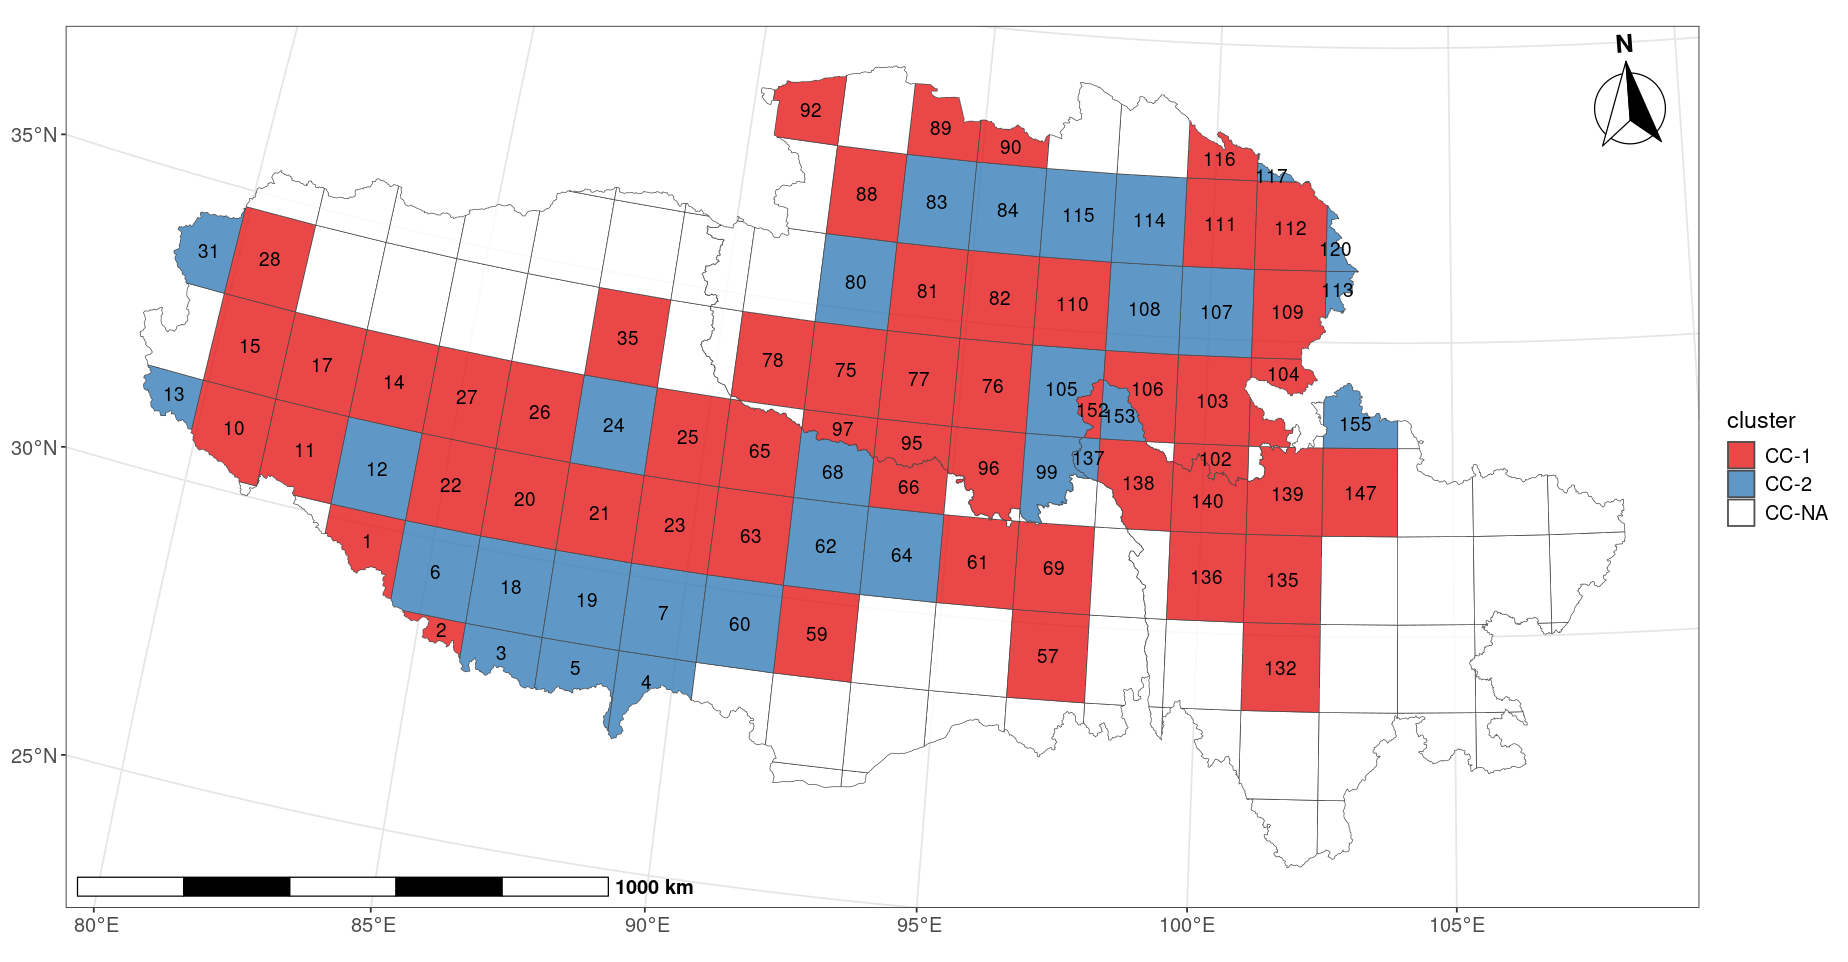

In [20]:
# Visualize clustering results
options(repr.plot.width = 15.4, repr.plot.height = 8.02)
new.map %>% plot_bmap(var = 'cluster', fill = c(RColorBrewer::brewer.pal(9, "Set1")[1:2], "white")) %>% 
    add_label(dat = new.map@data, lab.var = "NAME", lon.var = "X.CENTER", lat.var = "Y.CENTER", remove.na = TRUE) %>%
    add_scale_bar() %>% add_north_arrow() %>% add_crs()

## 4. Analysis based on the clustering of ASV/gene abundance tables in each grid

In [21]:
# K-mean clustering 
set.seed(123456)
dat.new <- aggregate(t(dataset.dts.aliyun$mat), by = list(metadata3$NAME), FUN = mean)
row.names(dat.new) <- dat.new[,1]; dat.new <- dat.new[,-1]
cls.num <- fpc::pamk(dat.new)$nc # automatically determining cluster number
kms <- kmeans(dat.new, centers = cls.num)
ctr <- data.frame(grids = names(kms$cluster), cluster = kms$cluster)

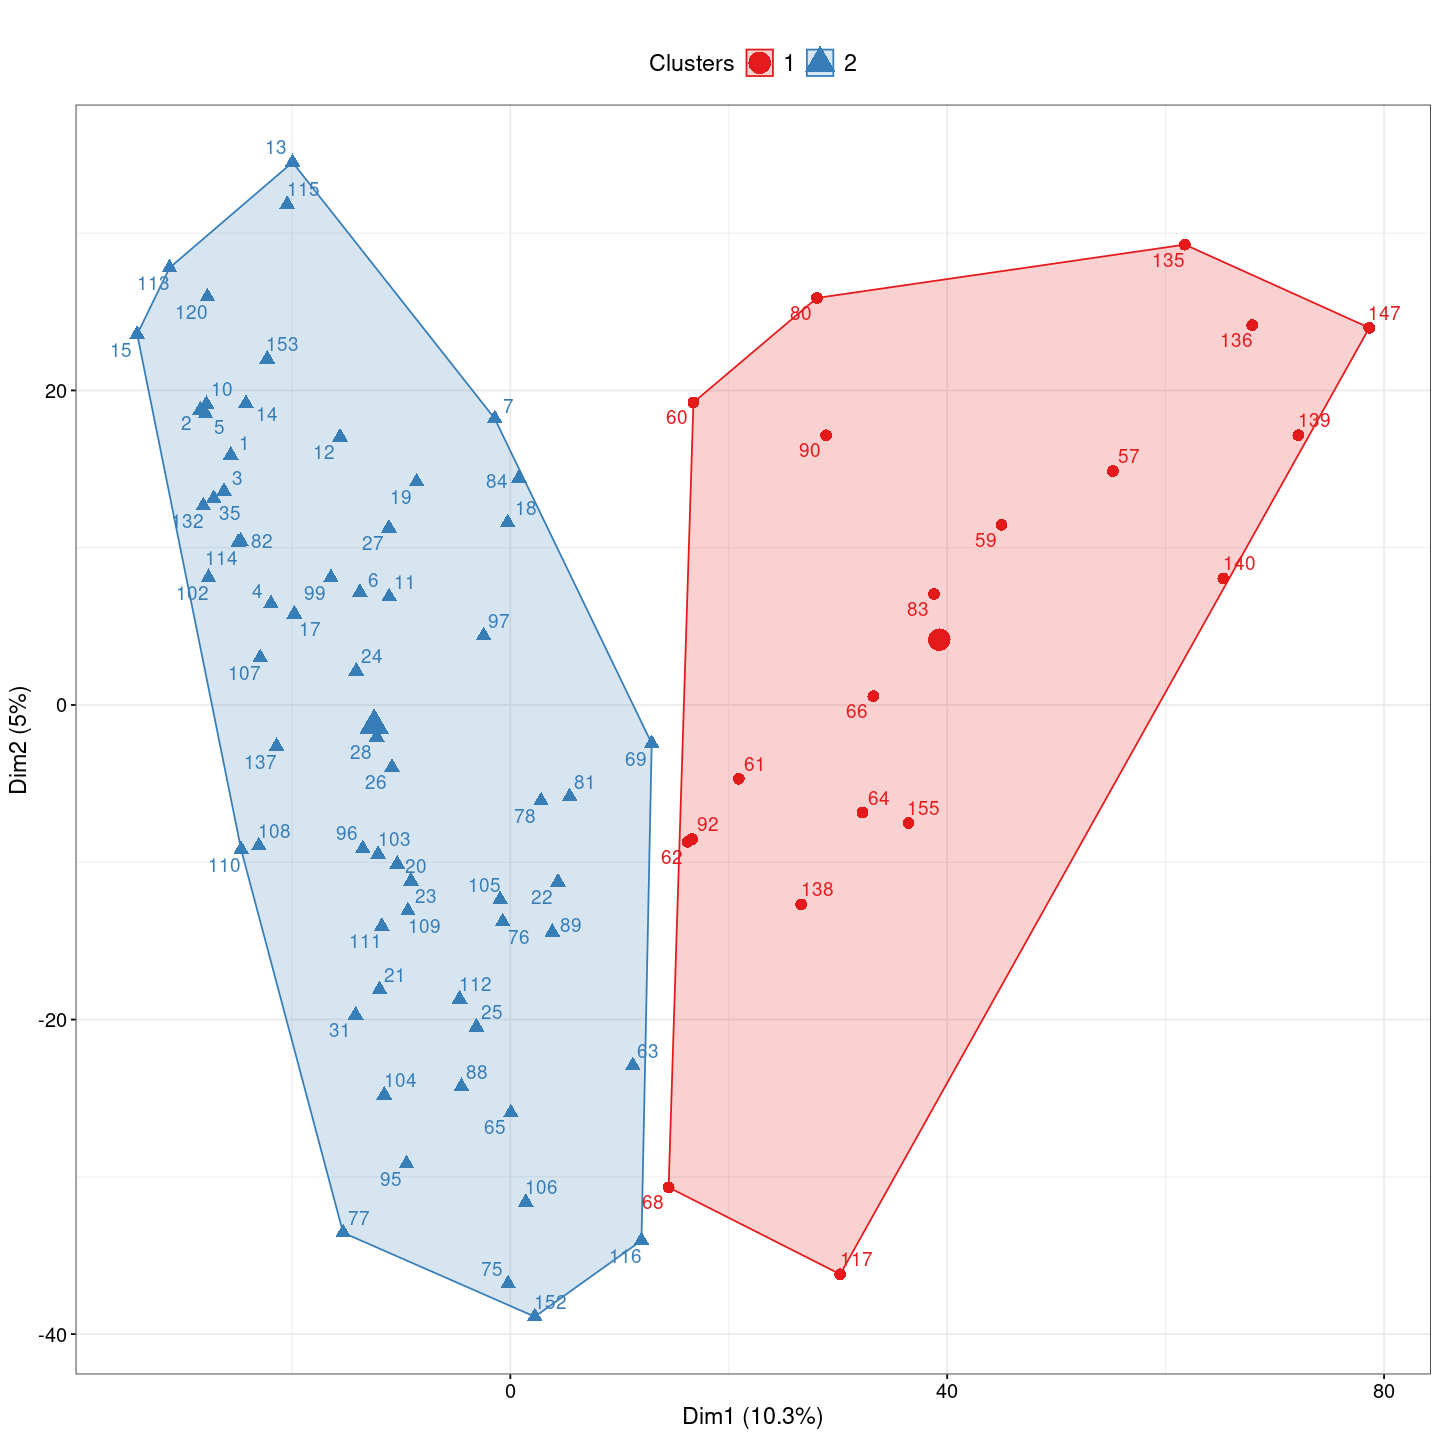

In [22]:
# Visualize the clustering results 
options(repr.plot.width = 12, repr.plot.height = 12)
factoextra::fviz_cluster(kms, data = dat.new, ggtheme = theme_bw(),
    main = "", repel = TRUE, show.clust.cent = TRUE, palette = RColorBrewer::brewer.pal(9, "Set1")[1:3], labelsize = 12, pointsize = 3,
    legend = 'top', font.x = c(14, "plain", "black"), font.y = c(14, "plain", "black"), legend.title = "Clusters",
    font.tickslab = c(12, "plain", "black"), font.legend = c(14, "plain", "black"))

In [23]:
# Add clustering results to metadata 
# The new metadata can be used for extensive statistical analysis
metadata3$cluster <- lapply(metadata3$NAME, function(x){
    dd <- ctr[which(ctr$grids == x),]
    res <- ifelse(nrow(dd) == 0, NA, dd$cluster)
}) %>% unlist()
metadata3$cluster <- paste0("KC-", metadata3$cluster)
head(metadata3)

,longitude,latitude,NAME,TYPE,FMTS,X.CENTER,Y.CENTER,cluster
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
s1,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,KC-1
s2,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,KC-1
s3,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,KC-1
s4,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,KC-1
s5,98.20894,33.10321,138,Gridded.Map,microgeo,98.70691,32.50087,KC-1
s6,98.20639,33.10280,138,Gridded.Map,microgeo,98.70691,32.50087,KC-1


In [24]:
# Merge clustering results with the gridded map
new.map <- gridded.map
mapdata.add.data <- lapply(new.map@data$NAME, function(name) {
    d <- ctr[which(ctr$grids == name),]
    ddd <- data.frame(grids = NA, cluster = NA)
    if (nrow(d) > 0) ddd <- d[,1:2]
    ddd
}) %>% do.call('rbind', .)
mapdata.add.data$cluster <- paste0("KC-", mapdata.add.data$cluster)
new.map@data <- cbind(new.map@data, mapdata.add.data)
head(new.map@data)

,TYPE,FMTS,NAME,X.CENTER,Y.CENTER,grids,cluster
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Gridded.Map,microgeo,1,83.74702,29.73742,1,KC-2
2,Gridded.Map,microgeo,2,85.46302,28.50944,2,KC-2
3,Gridded.Map,microgeo,3,86.67299,28.33105,3,KC-2
4,Gridded.Map,microgeo,4,89.49169,28.25211,4,KC-2
5,Gridded.Map,microgeo,5,88.12468,28.29693,5,KC-2
6,Gridded.Map,microgeo,6,85.14919,29.46224,6,KC-2


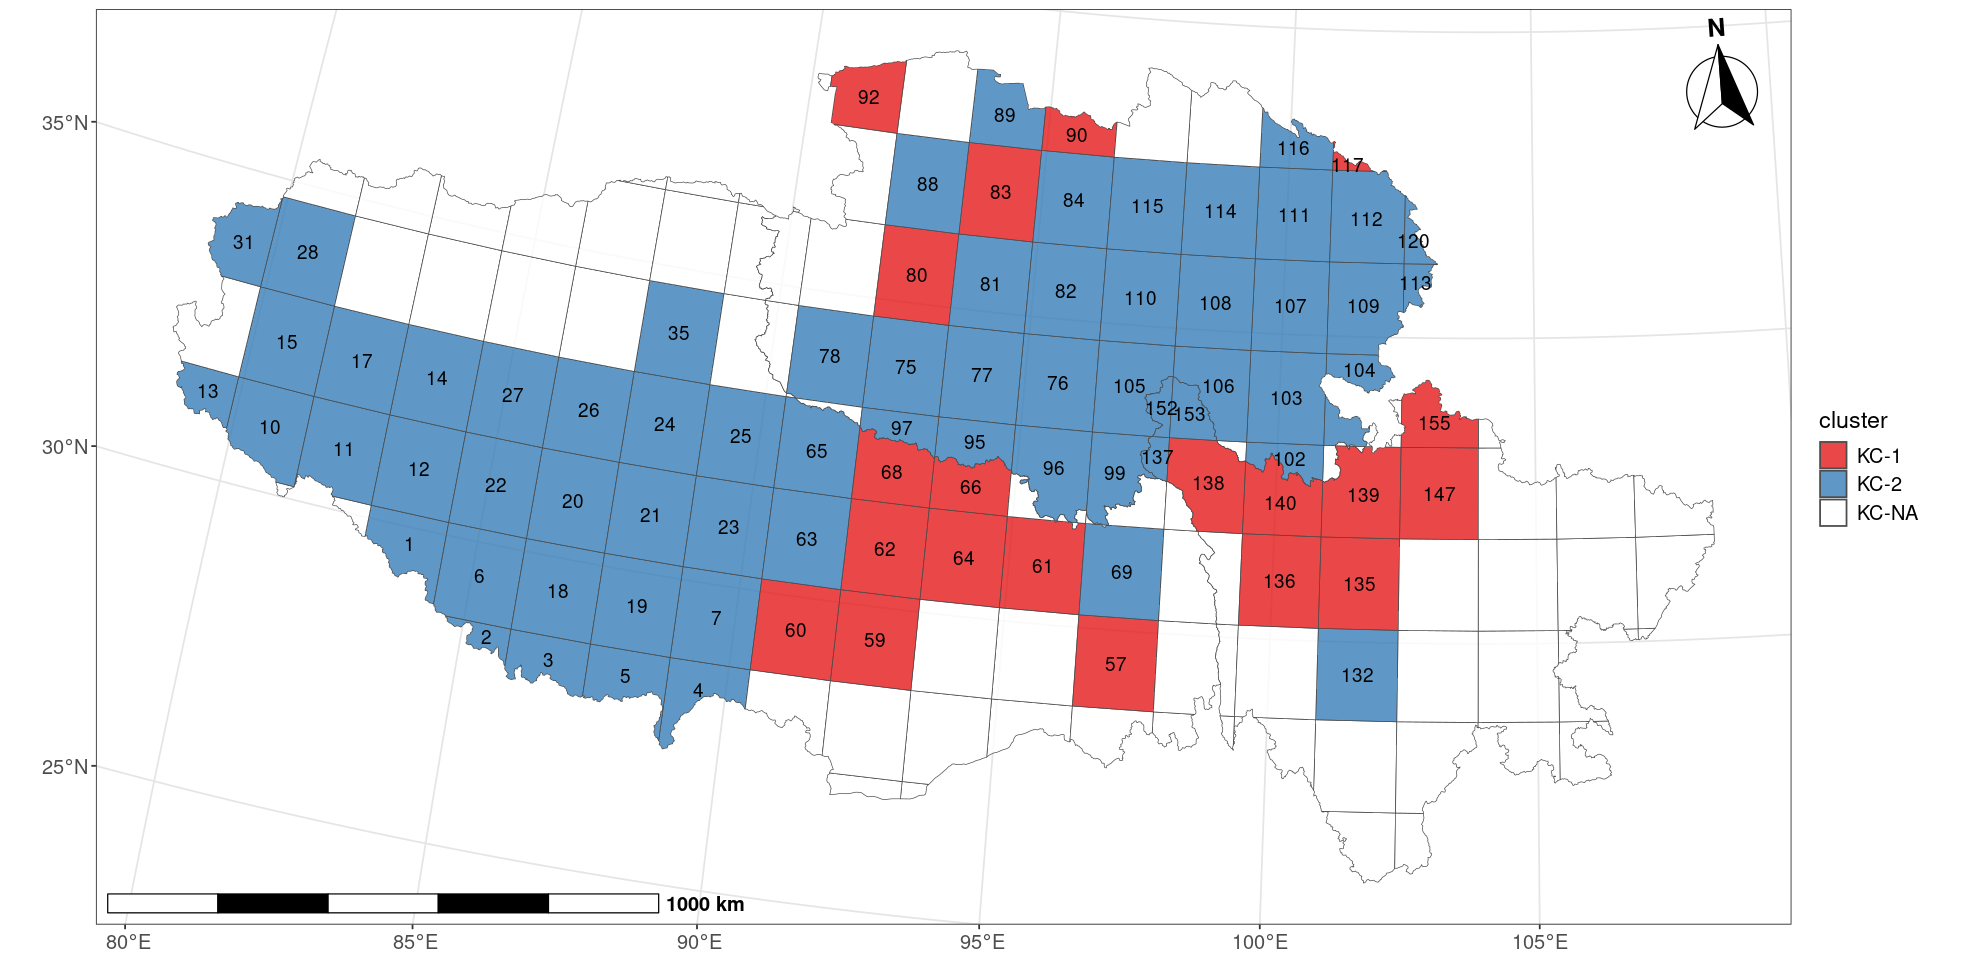

In [25]:
# Visualize clustering results
options(repr.plot.width = 16.4, repr.plot.height = 8.02)
new.map %>% plot_bmap(var = 'cluster', fill = c(RColorBrewer::brewer.pal(9, "Set1")[1:2], "white")) %>% 
    add_label(dat = new.map@data, lab.var = "NAME", lon.var = "X.CENTER", lat.var = "Y.CENTER", remove.na = TRUE) %>%
    add_scale_bar() %>% add_north_arrow() %>% add_crs()